# MBML 2023

## INIT

### Load Packages

In [18]:
import pandas as pd
import kaggle
import os
import shutil
import requests
import urllib
from urllib.request import urlopen, urlretrieve
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image
import numpy as np


from src.data import extract, load, transform

### Set Flags

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

DATA_DIR = "data/"

## Data

### Extract Data

In [ ]:
# Download Fligt Delay Dataset form Kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    "robikscube/flight-delay-dataset-20182022",
    path=DATA_DIR,
    unzip=True,
)
for filename in os.listdir(DATA_DIR):
    f = os.path.join(DATA_DIR, filename)
    if f.endswith(".parquet") or filename == "Airlines.csv":
        pass
    else:
        if os.path.isfile(f):
            os.remove(f)
        else:
            shutil.rmtree(f)

In [ ]:
# Download Location of airports
urlretrieve(
    "https://raw.githubusercontent.com/lxndrblz/Airports/main/airports.csv", 
    DATA_DIR + "airports.csv"
    )

### Transform Data

### Load Data

In [3]:
main_df = extract.combine_parquet(data_path = "data/")
main_df['count'] = 1
airport_df = pd.read_csv('data/airports.csv')
airline_df = pd.read_csv('data/Airlines.csv')

### Define display options for later export to pdf

In [4]:
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

In [5]:
# silence future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# set max number of rows of dataframe
pd.set_option('display.max_rows', 80)

### Describe Data

Display two first rows of data

In [39]:
# transposing dataframe and displaying in two different cells for compatability with pdf conversion
pd.DataFrame(main_df.iloc[:2,:30].T)

,0,1
FlightDate,2018-01-23 00:00:00,2018-01-24 00:00:00
Airline,Endeavor Air Inc.,Endeavor Air Inc.
Origin,ABY,ABY
Dest,ATL,ATL
Cancelled,False,False
Diverted,False,False
CRSDepTime,1202,1202
DepTime,1157.0,1157.0
DepDelayMinutes,0.0,0.0
DepDelay,-5.0,-5.0


In [40]:
pd.DataFrame(main_df.iloc[:2,30:].T)

,0,1
Flight_Number_Operating_Airline,3298,3298
OriginAirportID,10146,10146
OriginAirportSeqID,1014602,1014602
OriginCityMarketID,30146,30146
OriginCityName,"Albany, GA","Albany, GA"
OriginState,GA,GA
OriginStateFips,13,13
OriginStateName,Georgia,Georgia
OriginWac,34,34
DestAirportID,10397,10397


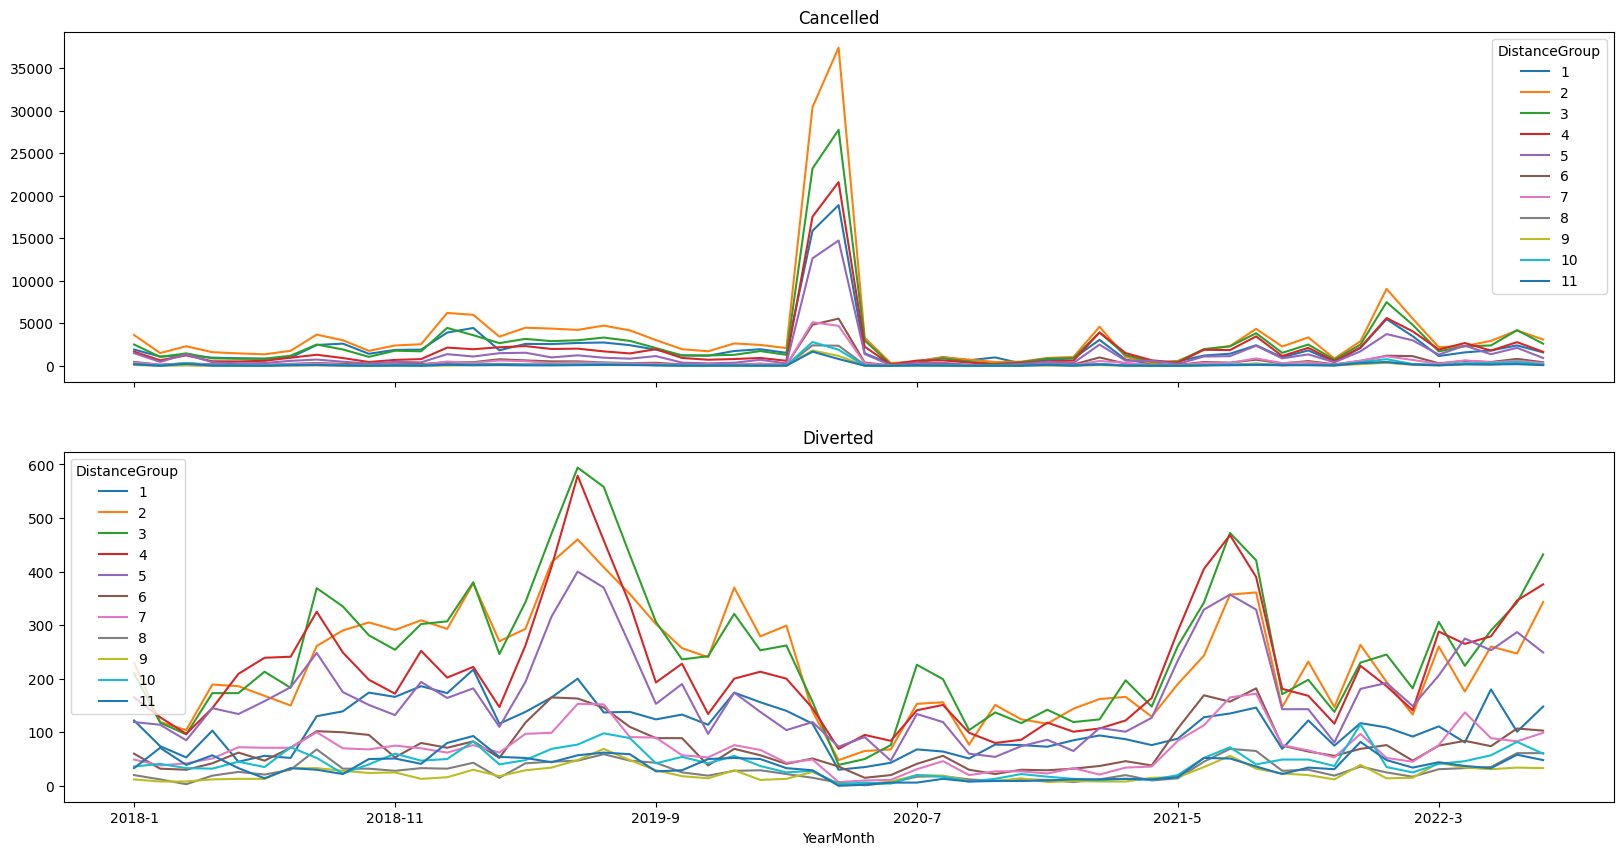

In [8]:
# Plot cancellations and Diverted by length of flight
g_main_df = main_df.groupby(["Year","Month","DistanceGroup"]).sum().unstack().reset_index()
g_main_df["YearMonth"] = g_main_df["Year"].astype(str)+"-"+g_main_df["Month"].astype(str)

subplots = 2
fig, ax = plt.subplots(subplots,1,figsize = (20,10))
prediction_cols = ["Cancelled","Diverted"]
for i in range(subplots):
    g_main_df[[prediction_cols[i],"YearMonth"]].plot(x="YearMonth",y=prediction_cols[i],kind = "line", legend = True,ax = ax[i],sharex = True,title = prediction_cols[i])

In [9]:
g_main_df = main_df.groupby(["OriginState"]).sum()

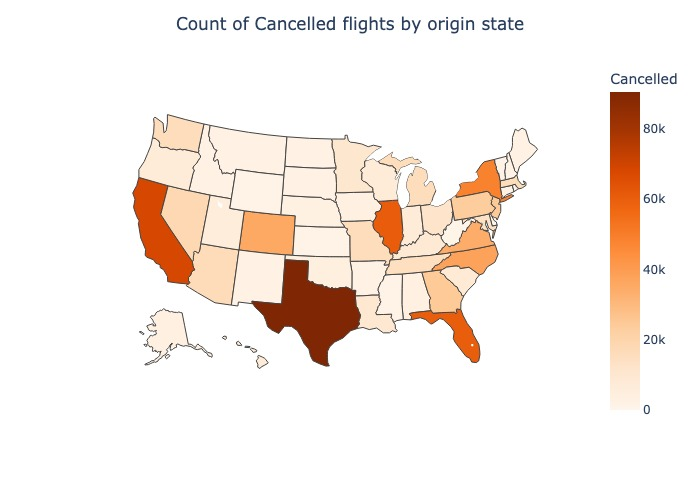

In [10]:
# plot a choropleth with color range by count per state
fig = px.choropleth(g_main_df['Cancelled'].reset_index(),
                    locations='OriginState',
                    locationmode="USA-states",
                    scope="usa",
                    color="Cancelled",
                    color_continuous_scale="Oranges",
                   )
# center the title
fig.update_layout(title_text='Count of Cancelled flights by origin state', title_x=0.5)

# export plot to image to compatability with jupyter conversion
#fig.show()
im = fig.to_image("jpeg")
Image(im)

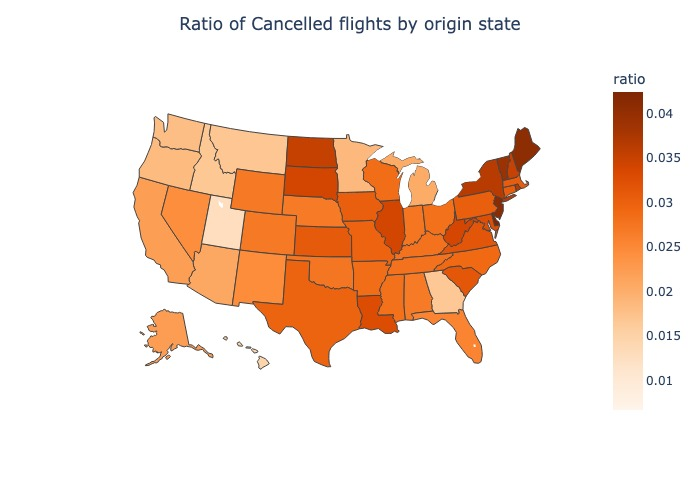

In [11]:
state_df = g_main_df[['Cancelled','count']].reset_index()
state_df["ratio"] = state_df['Cancelled']/state_df['count']

# plot a choropleth with color range by count per state
fig = px.choropleth(state_df,
                    locations='OriginState',
                    locationmode="USA-states",
                    scope="usa",
                    color="ratio",
                    color_continuous_scale="Oranges",
                   )
# center the title
fig.update_layout(title_text='Ratio of Cancelled flights by origin state', title_x=0.5)

# export plot to image to compatability with pdf conversion
#fig.show()
im = fig.to_image("jpeg")
Image(im)